In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
#from desi_retriever.denali import get_specs
import matplotlib.cm as cm
import scipy.ndimage as sn
import my_plot_style as mps
import desispec.tsnr as dts 
mps.my_plot_style()

In [2]:
def matching_pernight_cumulative_VI_data(pernight_data,cumulative_data,target_name):
    if target_name=='BGS':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/BGS_ANY/'
        dataname = 'allVItiles_BGS_ANYzinfo_wVI.fits'
    
    elif target_name=='LRG':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/LRG/'
        dataname = 'allVItiles_LRGzinfo_wVI.fits'
    
    elif target_name=='ELG':
        diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/ELG/'
        dataname = 'allVItiles_ELGzinfo_wVI.fits'
    
    VI_data = Table.read(diretory+dataname)
    VI_data = VI_data[(VI_data['subset']=='deep') & (VI_data['subset']!='All') & ((VI_data['N_VI']>0))]
    VI_data = VI_data['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC'
                        ,'FIBERFLUX_R','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER','best_z','best_quality','N_VI','all_VI_comments','merger_comment'].to_pandas()
    
    catalog_match = pernight_dataset.merge(everest_dataset,on='TARGETID',how='left',suffixes=("_pernight","_cumulative"))
    final_match_catalog = catalog_match[catalog_match['TILEID_pernight']==catalog_match['TILEID_cumulative']]
    
    #catalog_match = everest_data.merge(VI_data,on='TARGETID',how='left',suffixes=("","_VI"))
    #final_match_catalog = catalog_match[catalog_match['TILEID']==catalog_match['TILEID_VI']]

    final_match_catalog = final_match_catalog.merge(VI_data,on='TARGETID',how='left',suffixes=("","_VI"))
    final_match_catalog = final_match_catalog[final_match_catalog['TILEID_pernight']==final_match_catalog['TILEID']]
    final_match_catalog['dz_pernight_VI'] = abs(final_match_catalog['Z_pernight']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])
    final_match_catalog['dz_pernight_cumulative'] = abs(final_match_catalog['Z_pernight']-final_match_catalog['Z_cumulative'])/(1.+final_match_catalog['Z_cumulative'])

    return final_match_catalog    

In [3]:
def main_survey_selection(data,target_type):
    new_catalog = data.copy()
    new_catalog['zmag']=-2.5*np.log10(new_catalog['FLUX_Z'])+22.5-1.211*new_catalog['EBV']
    new_catalog['gmag']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
    new_catalog['rmag']=-2.5*np.log10(new_catalog['FLUX_R'])+22.5-2.165*new_catalog['EBV']
    new_catalog['GTOT']=-2.5*np.log10(new_catalog['FLUX_G'])+22.5-3.214*new_catalog['EBV']
    new_catalog['GFIB']=-2.5*np.log10(new_catalog['FIBERFLUX_G'])+22.5-3.214*new_catalog['EBV']
    new_catalog['RFIB']=-2.5*np.log10(new_catalog['FIBERFLUX_R'])+22.5-2.165*new_catalog['EBV']
    new_catalog['ZFIB']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']

    new_catalog['W1']=-2.5*np.log10(new_catalog['FLUX_W1'])+22.5-0.184*new_catalog['EBV']
    
    new_catalog['RZ']=new_catalog['rmag']-new_catalog['zmag']
    new_catalog['GR']=new_catalog['gmag']-new_catalog['rmag']
    new_catalog['color']=(new_catalog['zmag']-new_catalog['W1'])-1.2*(new_catalog['gmag']-new_catalog['rmag'])+1.2
    new_catalog['ZW1']=new_catalog['zmag']-new_catalog['W1']
    new_catalog['RW1']=new_catalog['rmag']-new_catalog['W1']

    if target_type=='ELG_main':
    
        SV3_selection = ((new_catalog['GTOT']>20) &
                        (new_catalog['GFIB']<24.1) &
                        (new_catalog['RZ']>0.15) & 
                        (new_catalog['GR']<0.1+0.5*new_catalog['RZ']) &
                        (new_catalog['GR']<-1.2*new_catalog['RZ']+1.6))
    
    elif target_type=='ELG_top':
    
        SV3_selection = ((new_catalog['GTOT']>20) &
                        (new_catalog['GFIB']<24.1) &
                        (new_catalog['RZ']>0.15) & 
                        (new_catalog['GR']<0.1+0.5*new_catalog['RZ']) &
                        (new_catalog['GR']<-1.2*new_catalog['RZ']+1.3))
    
    elif target_type=='ELG_low':
    
        SV3_selection = ((new_catalog['GTOT']>20) &
                        (new_catalog['GFIB']<24.1) &
                        (new_catalog['RZ']>0.15) & 
                        (new_catalog['GR']<0.1+0.5*new_catalog['RZ']) &
                        (new_catalog['GR']>-1.2*new_catalog['RZ']+1.3) & (new_catalog['GR']<-1.2*new_catalog['RZ']+1.6))

        
    elif target_type=='BGS_main':
        SV3_selection = (
            ((new_catalog['PHOTSYS']==b'S') & ((new_catalog['RFIB']<20.75) | ((new_catalog['RFIB']<21.5) & (new_catalog['color']>0)))) |            
            ((new_catalog['PHOTSYS']==b'N') & ((new_catalog['RFIB']<20.75+0.04) | ((new_catalog['RFIB']<21.5+0.04) & (new_catalog['color']>0)))))   
        #deltachi2_selection = new_catalog['DELTACHI2']>40
        #SV3_selection = SV3_selection & deltachi2_selection
    
    elif target_type=='LRG_main':
        
        SV3_selection = (
            ((new_catalog['PHOTSYS']==b'S') & (new_catalog['ZFIB']<21.7) &
            (new_catalog['ZW1']>0.8*new_catalog['RZ']-0.6) & 
            (((new_catalog['GR']>1.3) & (new_catalog['GR']>-1.55*(new_catalog['RW1']+3.13))) |  (new_catalog['RW1']>1.8)) &
            (((new_catalog['RW1']>(new_catalog['W1']-17.07)*1.8) & (new_catalog['RW1']>(new_catalog['W1']-16.17)*1))  | (new_catalog['RW1']>3.29))) |
            
            ((new_catalog['PHOTSYS']==b'N') & (new_catalog['ZFIB']<21.72) &
            (new_catalog['ZW1']>0.8*new_catalog['RZ']-0.6) & 
            (((new_catalog['GR']>1.34) & (new_catalog['GR']>-1.55*(new_catalog['RW1']+3.23))) |  (new_catalog['RW1']>1.8)) &
            (((new_catalog['RW1']>(new_catalog['W1']-17.24)*1.83) & (new_catalog['RW1']>(new_catalog['W1']-16.33)*1))  | (new_catalog['RW1']>3.39)))
        )
       # deltachi2_selection = (new_catalog['Z']>0.4) & (new_catalog['Z']<1.4) & (new_catalog['DELTACHI2']>15)
       # SV3_selection = SV3_selection & deltachi2_selection    
    return new_catalog[SV3_selection]

In [4]:
directory = '/global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/'

In [5]:
pernight_data = Table.read('/global/u2/t/tlan/ztile-sv1-perexp.fits',1)
everest_all = Table.read(directory+'ztile-sv1-cumulative.fits',1)

In [210]:
pernight_data2 = Table.read('/global/u2/t/tlan/ztile-sv1-perexp.fits',2)


TARGETID,PRIORITY,SUBPRIORITY,NIGHT,EXPID,MJD,TILEID,EXPTIME,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,FIBERASSIGN_X,FIBERASSIGN_Y,LAMBDA_REF,PLATE_RA,PLATE_DEC,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,PSF_TO_FIBER_SPECFLUX
int64,int32,float64,int32,int32,float64,int32,float64,int16,int32,int64,int32,int32,float32,float32,float32,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
616088398876115508,-1,0.9512236328746354,20201214,67710,59198.17546592,80605,900.0,0,311,311,0,1024,81.659775,-287.25793,5400.0,36.1197195711802,-5.755705260506989,2,81.622,-287.226,0.009,0.032,36.119681726528164,-5.75558136496302,0.7962365287482441
39627646576887581,3000,0.8200372567280423,20201214,67710,59198.17546592,80605,900.0,0,272,272,1,0,59.12405,-273.62305,5400.0,36.21001350466946,-5.703928718537166,2,59.09,-273.588,0.008,0.026,36.209980213881785,-5.703827469496334,0.7469541252612752
616088398880310134,-1,0.9339943891627359,20201214,67710,59198.17546592,80605,900.0,0,252,252,2,0,31.166435,-269.98404,5400.0,36.32306874215957,-5.690429514993079,2,31.143,-269.948,0.002,0.026,36.32306008227113,-5.690328314881218,0.7949336320398291
39627652595713438,3400,0.3466496878557428,20201214,67710,59198.17546592,80605,900.0,0,156,156,3,0,2.3623955,-220.44301,5400.0,36.43953411598538,-5.496381561333345,2,2.336,-220.419,0.006,0.025,36.43950948496094,-5.496282405800299,0.7889999999999998
39627646581084149,3400,0.9187081985115158,20201214,67710,59198.17546592,80605,900.0,0,198,198,4,0,-19.509655,-255.12762,5400.0,36.52861808159879,-5.632503049753665,2,-19.527,-255.086,0.004,0.02,36.52860191952559,-5.63242478152684,0.7889999999999998
39627652591522151,3200,0.31684841868175107,20201214,67710,59198.17546592,80605,900.0,0,204,204,5,1024,42.023426,-240.23544,5400.0,36.278283134385994,-5.5741355587364705,2,41.994,-240.213,0.004,0.03,36.278266139247975,-5.574017395996525,0.6615863682085972
39627646576893124,3000,0.9414281312595538,20201214,67710,59198.17546592,80605,900.0,0,233,233,6,0,13.012635,-263.11725,5400.0,36.39657602853026,-5.663883068137146,2,12.991,-263.083,0.002,0.027,36.39656759418969,-5.66377768244425,0.7628109890130252
39627652591525655,3000,0.7243188742879026,20201214,67710,59198.17546592,80605,900.0,0,172,172,7,0,15.736794,-225.90718,5400.0,36.38503496760173,-5.517985497586557,2,15.707,-225.884,0.008,0.027,36.38500203452295,-5.51787855633183,0.7204806597703453
39627646576885924,3400,0.6095334550675201,20201214,67710,59198.17546592,80605,900.0,0,310,310,8,1024,72.98088,-286.48608,5400.0,36.15463214762754,-5.7531064283296685,2,72.943,-286.452,0.01,0.03,36.1545904779946,-5.752990167454285,0.7889999999999998


In [8]:
pernight_dataset = pernight_data['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC','COADD_EXPTIME','ZWARN','SPECTYPE','SV1_DESI_TARGET','PHOTSYS','COADD_FIBERSTATUS','TSNR2_LRG',
                              'TSNR2_ELG','TSNR2_BGS','SV1_BGS_TARGET'].to_pandas()
everest_dataset = everest_all['TARGETID','Z','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC','COADD_EXPTIME','COADD_FIBERSTATUS',
                              'TSNR2_ELG','FIBERFLUX_R','FIBERFLUX_G','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER','FIBERTOTFLUX_G','TSNR2_LRG','TSNR2_BGS'].to_pandas()

In [9]:
catalog_match = pernight_dataset.merge(everest_dataset,on='TARGETID',how='left',suffixes=("_pernight","_cumulative"))
#final_match_catalog=matching_pernight_cumulative_VI_data(pernight_dataset,everest_dataset,'LRG')
final_match_catalog = catalog_match[catalog_match['TILEID_pernight']==catalog_match['TILEID_cumulative']]
final_match_catalog['dz_pernight_cumulative'] = abs(final_match_catalog['Z_pernight']-final_match_catalog['Z_cumulative'])/(1.+final_match_catalog['Z_cumulative'])

<ipython-input-9-ca7f1facb7fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['dz_pernight_cumulative'] = abs(final_match_catalog['Z_pernight']-final_match_catalog['Z_cumulative'])/(1.+final_match_catalog['Z_cumulative'])


In [10]:
final_match_catalog['EFFTIME_LRG_pernight']=dts.tsnr2_to_efftime(final_match_catalog['TSNR2_ELG_pernight'], 'ELG')
final_match_catalog['EFFTIME_LRG_cumulative']=dts.tsnr2_to_efftime(final_match_catalog['TSNR2_ELG_cumulative'], 'ELG')
final_match_catalog['EFFTIME_BGS_pernight']=dts.tsnr2_to_efftime(final_match_catalog['TSNR2_BGS_pernight'], 'BGS')
final_match_catalog['EFFTIME_BGS_cumulative']=dts.tsnr2_to_efftime(final_match_catalog['TSNR2_BGS_cumulative'], 'BGS')

INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/master/data/tsnr/tsnr-ensemble-gpbdark.fits apply scale factor = 1.000
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/master/data/tsnr/tsnr-ensemble-elg.fits apply scale factor = 1.261
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/master/data/tsnr/tsnr-ensemble-gpbbright.fits apply scale factor = 1.000
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/master/data/tsnr/tsnr-ensemble-lya.fits apply scale factor = 0.998
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/master/data/tsnr/tsnr-ensemble-bgs.fits apply scale factor = 2.652
INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/202008

<ipython-input-10-0f2dff17d576>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['EFFTIME_LRG_pernight']=dts.tsnr2_to_efftime(final_match_catalog['TSNR2_ELG_pernight'], 'ELG')
<ipython-input-10-0f2dff17d576>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['EFFTIME_LRG_cumulative']=dts.tsnr2_to_efftime(final_match_catalog['TSNR2_ELG_cumulative'], 'ELG')
<ipython-input-10-0f2dff17d576>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

INFO:tsnr.py:444:get_ensemble: for /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/master/data/tsnr/tsnr-ensemble-lrg.fits apply scale factor = 2.392
INFO:tsnr.py:464:get_ensemble: iotime 0.084 sec to read tsnr ensemble at 2021-07-29T20:52:05.481170
INFO:tsnr.py:1160:tsnr2_to_efftime: for tracer bgs SNR2TIME=0.140000


<ipython-input-10-0f2dff17d576>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['EFFTIME_BGS_cumulative']=dts.tsnr2_to_efftime(final_match_catalog['TSNR2_BGS_cumulative'], 'BGS')


In [11]:
from desitarget.sv1 import sv1_targetmask
LRG_mask = (final_match_catalog["SV1_DESI_TARGET"] & sv1_targetmask.desi_mask["LRG"]) > 0
#QSO_mask = ((final_match_catalog["SV1_DESI_TARGET"] & sv1_targetmask.desi_mask["QSO"]) > 0)
exposure_mask = (final_match_catalog['EFFTIME_LRG_pernight']>850) & (final_match_catalog['EFFTIME_LRG_pernight']<950) & (final_match_catalog['EFFTIME_LRG_cumulative']>4000)# & (final_match_catalog['EFFTIME_LRG_pernight']<10000)

quality_mask = ((final_match_catalog['DELTACHI2_cumulative']>15) & (final_match_catalog['Z_cumulative']<1.4) & (final_match_catalog['Z_cumulative']>0.4) & 
    #(final_match_catalog['ZWARN_cumulative']==0) &
    (final_match_catalog['COADD_FIBERSTATUS_cumulative']==0) &
    #(final_match_catalog['ZWARN_pernight']==0) &
    (final_match_catalog['COADD_FIBERSTATUS_pernight']==0)
               )
'''               
quality_mask = ((final_match_catalog['best_quality']>=2.5) & (final_match_catalog['best_z']<1.4) & (final_match_catalog['best_z']>0.4) & 
    #(final_match_catalog['ZWARN_cumulative']==0) &
    (final_match_catalog['COADD_FIBERSTATUS_cumulative']==0) &
    #(final_match_catalog['ZWARN_pernight']==0) &
    (final_match_catalog['COADD_FIBERSTATUS_pernight']==0)
               )
'''

"               \nquality_mask = ((final_match_catalog['best_quality']>=2.5) & (final_match_catalog['best_z']<1.4) & (final_match_catalog['best_z']>0.4) & \n    #(final_match_catalog['ZWARN_cumulative']==0) &\n    (final_match_catalog['COADD_FIBERSTATUS_cumulative']==0) &\n    #(final_match_catalog['ZWARN_pernight']==0) &\n    (final_match_catalog['COADD_FIBERSTATUS_pernight']==0)\n               )\n"

In [12]:
LRG = final_match_catalog[LRG_mask & exposure_mask & quality_mask]
LRG_main = main_survey_selection(LRG,'LRG_main')

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
print(len(LRG_main))

4311


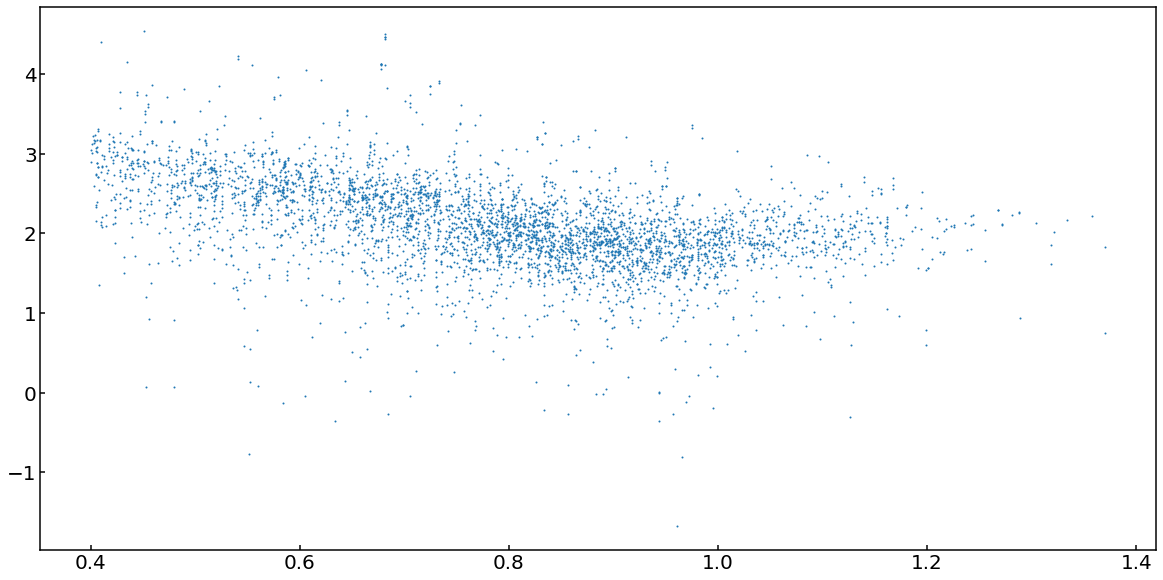

In [14]:
plt.figure(figsize=(20,10))
plt.scatter(LRG_main['Z_cumulative'],np.log10(LRG_main['DELTACHI2_pernight']),s=1)

In [15]:
short_exposure_mask = (LRG_main['DELTACHI2_pernight']>15) & (LRG_main['dz_pernight_cumulative']<0.0033)# & (LRG_main['Z_pernight']<1.4)

In [16]:
LRG_short = LRG_main[short_exposure_mask]

In [17]:
len(LRG_short)

4103

In [18]:
len(LRG_main)

4311

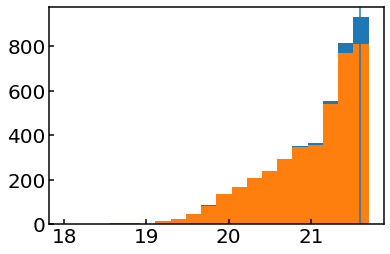

In [19]:
out1 = plt.hist(LRG_main['ZFIB'],range=(18,21.7),bins=20)
out2 = plt.hist(LRG_short['ZFIB'],range=(18,21.7),bins=20)
plt.axvline(21.6)

In [20]:
1.*out2[0]/out1[0]

<ipython-input-20-d3fcbf0b0ad7>:1: RuntimeWarning: invalid value encountered in true_divide
  1.*out2[0]/out1[0]


array([       nan,        nan,        nan, 1.        , 0.75      ,
       1.        , 1.        , 1.        , 1.        , 0.98823529,
       0.99264706, 0.99408284, 1.        , 0.9958159 , 1.        ,
       0.98860399, 0.98076923, 0.96942446, 0.94464945, 0.87003222])

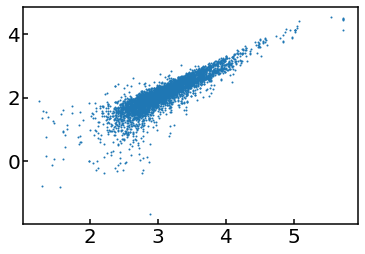

In [21]:
plt.scatter(np.log10(LRG_main['DELTACHI2_cumulative']),np.log10(LRG_main['DELTACHI2_pernight']),s=1)

In [200]:
from desitarget.sv1 import sv1_targetmask

BGS_mask = (final_match_catalog["SV1_BGS_TARGET"] & (sv1_targetmask.bgs_mask["BGS_BRIGHT"] | sv1_targetmask.bgs_mask["BGS_FAINT"])) > 0
#QSO_mask = ((final_match_catalog["SV1_DESI_TARGET"] & sv1_targetmask.desi_mask["QSO"]) > 0)
exposure_mask = (final_match_catalog['EFFTIME_BGS_pernight']>150) & (final_match_catalog['EFFTIME_BGS_pernight']<200) & (final_match_catalog['EFFTIME_BGS_cumulative']>600)# & (final_match_catalog['EFFTIME_LRG_pernight']<10000)

quality_mask = ((final_match_catalog['Z_cumulative']<0.5) & (final_match_catalog['Z_cumulative']>0.003) & (final_match_catalog['Z_pernight']<1.0) &
    #(final_match_catalog['ZWARN_cumulative']==0) &
    (final_match_catalog['COADD_FIBERSTATUS_cumulative']==0) &
    #(final_match_catalog['ZWARN_pernight']==0) &
    (final_match_catalog['COADD_FIBERSTATUS_pernight']==0)
               )
'''               
quality_mask = ((final_match_catalog['best_quality']>=2.5) & (final_match_catalog['best_z']<1.4) & (final_match_catalog['best_z']>0.4) & 
    #(final_match_catalog['ZWARN_cumulative']==0) &
    (final_match_catalog['COADD_FIBERSTATUS_cumulative']==0) &
    #(final_match_catalog['ZWARN_pernight']==0) &
    (final_match_catalog['COADD_FIBERSTATUS_pernight']==0)
               )
'''

"               \nquality_mask = ((final_match_catalog['best_quality']>=2.5) & (final_match_catalog['best_z']<1.4) & (final_match_catalog['best_z']>0.4) & \n    #(final_match_catalog['ZWARN_cumulative']==0) &\n    (final_match_catalog['COADD_FIBERSTATUS_cumulative']==0) &\n    #(final_match_catalog['ZWARN_pernight']==0) &\n    (final_match_catalog['COADD_FIBERSTATUS_pernight']==0)\n               )\n"

In [201]:
BGS = final_match_catalog[BGS_mask & quality_mask & exposure_mask]

In [202]:
BGS_main = main_survey_selection(BGS,'BGS_main')

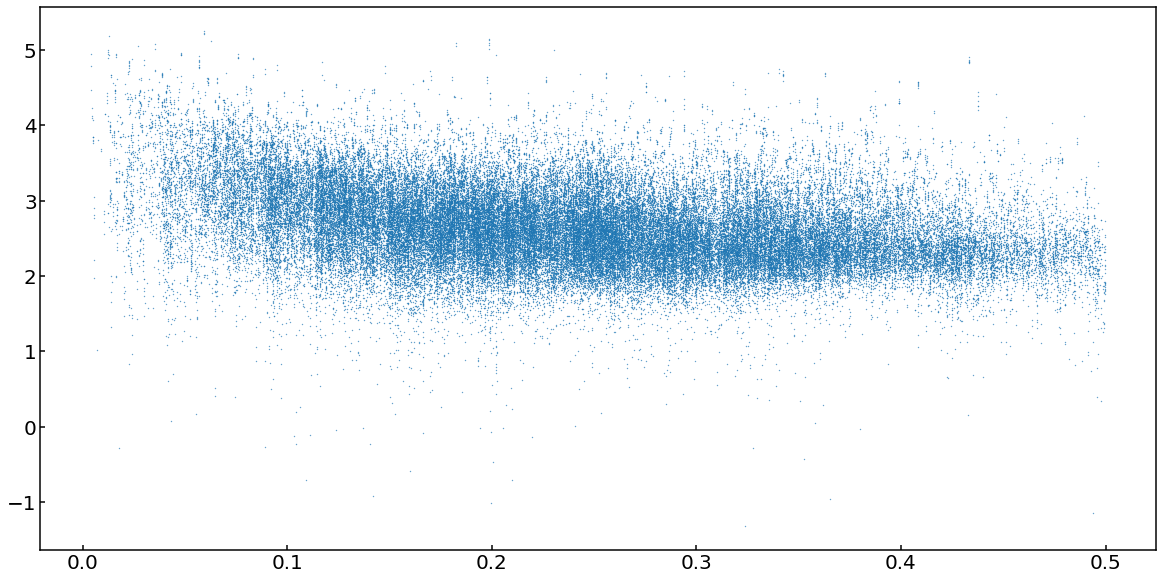

In [203]:
plt.figure(figsize=(20,10))
plt.scatter(BGS_main['Z_cumulative'],np.log10(BGS_main['DELTACHI2_pernight']),s=0.1)

In [204]:
short_exposure_mask = (BGS_main['DELTACHI2_pernight']>40) & (BGS_main['dz_pernight_cumulative']<0.0033)# & (LRG_main['Z_pernight']<1.4)

In [205]:
BGS_short = BGS_main[short_exposure_mask]

In [206]:
len(BGS_main)

87099

In [207]:
len(BGS_short)

85876

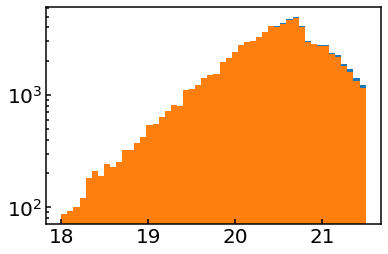

In [208]:
out1 = plt.hist(BGS_main['RFIB'],range=(18,21.5),bins=50)
out2 = plt.hist(BGS_short['RFIB'],range=(18,21.5),bins=50)
plt.yscale('log')

In [196]:
out2[0]/out1[0]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.9982238 , 1.        , 0.99789769, 0.99802502,
       1.        , 1.        , 0.99672131, 0.99544702, 0.99927693,
       0.9979886 , 0.99800664, 0.99548465, 0.99402011, 0.99227053,
       0.98642095, 0.9846295 , 0.97286013, 0.97834804, 0.97845558,
       0.98967355, 0.98850575, 0.98320829, 0.98629149, 0.97358491,
       0.96046202, 0.95668251, 0.95569994, 0.93824561, 0.93106245])

In [197]:
out2

(array([  86.,   93.,  100.,  121.,  183.,  210.,  190.,  242.,  226.,
         255.,  323.,  320.,  376.,  423.,  541.,  554.,  632.,  715.,
         806.,  805., 1103., 1124., 1220., 1424., 1516., 1531., 1974.,
        2128., 2405., 2764., 2977., 3004., 3307., 3657., 4108., 4068.,
        4292., 4660., 4880., 4042., 2971., 2838., 2752., 2734., 2322.,
        2162., 1811., 1618., 1337., 1148.]),
 array([18.  , 18.07, 18.14, 18.21, 18.28, 18.35, 18.42, 18.49, 18.56,
        18.63, 18.7 , 18.77, 18.84, 18.91, 18.98, 19.05, 19.12, 19.19,
        19.26, 19.33, 19.4 , 19.47, 19.54, 19.61, 19.68, 19.75, 19.82,
        19.89, 19.96, 20.03, 20.1 , 20.17, 20.24, 20.31, 20.38, 20.45,
        20.52, 20.59, 20.66, 20.73, 20.8 , 20.87, 20.94, 21.01, 21.08,
        21.15, 21.22, 21.29, 21.36, 21.43, 21.5 ], dtype=float32),
 <a list of 50 Patch objects>)

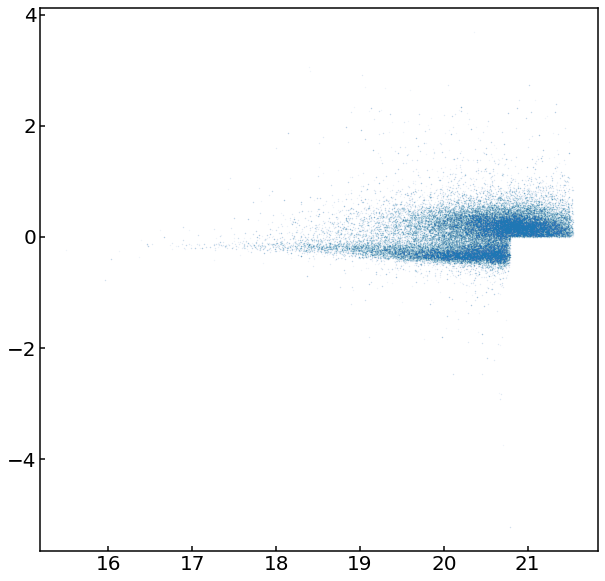

In [172]:
plt.figure(figsize=(10,10))
plt.scatter(BGS_main['RFIB'],BGS_main['color'],s=0.1,alpha=0.1)